<a href="https://colab.research.google.com/github/SaNadira/IMDB_Classification/blob/main/IMDB_FINALVERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [ ]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


PRE PROCESSING + SPLITTING DATA

In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")
#pre_processing :

def preprocessor (text) :
  text = re.sub(r"<[^>]+>", "", text)
  text = re.sub(r'\dt', '', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r'\W', ' ', text)
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  words= text.split()
  words=[word for word in words if word not in stop_words]
  return ' '.join(words)

df['processed_review'] = df['review'].apply(preprocessor)
df['label']=df['sentiment'].map({'positive': 1 , 'negative' : 0})

# splitting data frame into 1-train 2-validation 3-test  :

train_texts , sec_texts , train_labels , sec_labels = train_test_split(
  df['processed_review'],df['label'],test_size=0.3 , random_state= 42
)
validation_texts ,test_texts ,validation_labels ,test_labels = train_test_split (
  sec_texts , sec_labels , test_size=1/3 , random_state=42
)
print (df['processed_review'])
print ( df['label'])


0        one reviewers mentioned watching 1 oz episode ...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    im going disagree previous comment side maltin...
49999    one expects star trek movies high art fans exp...
Name: processed_review, Length: 50000, dtype: object
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: label, Length: 50000, dtype: int64


UNIGRAM'S BAR CHART

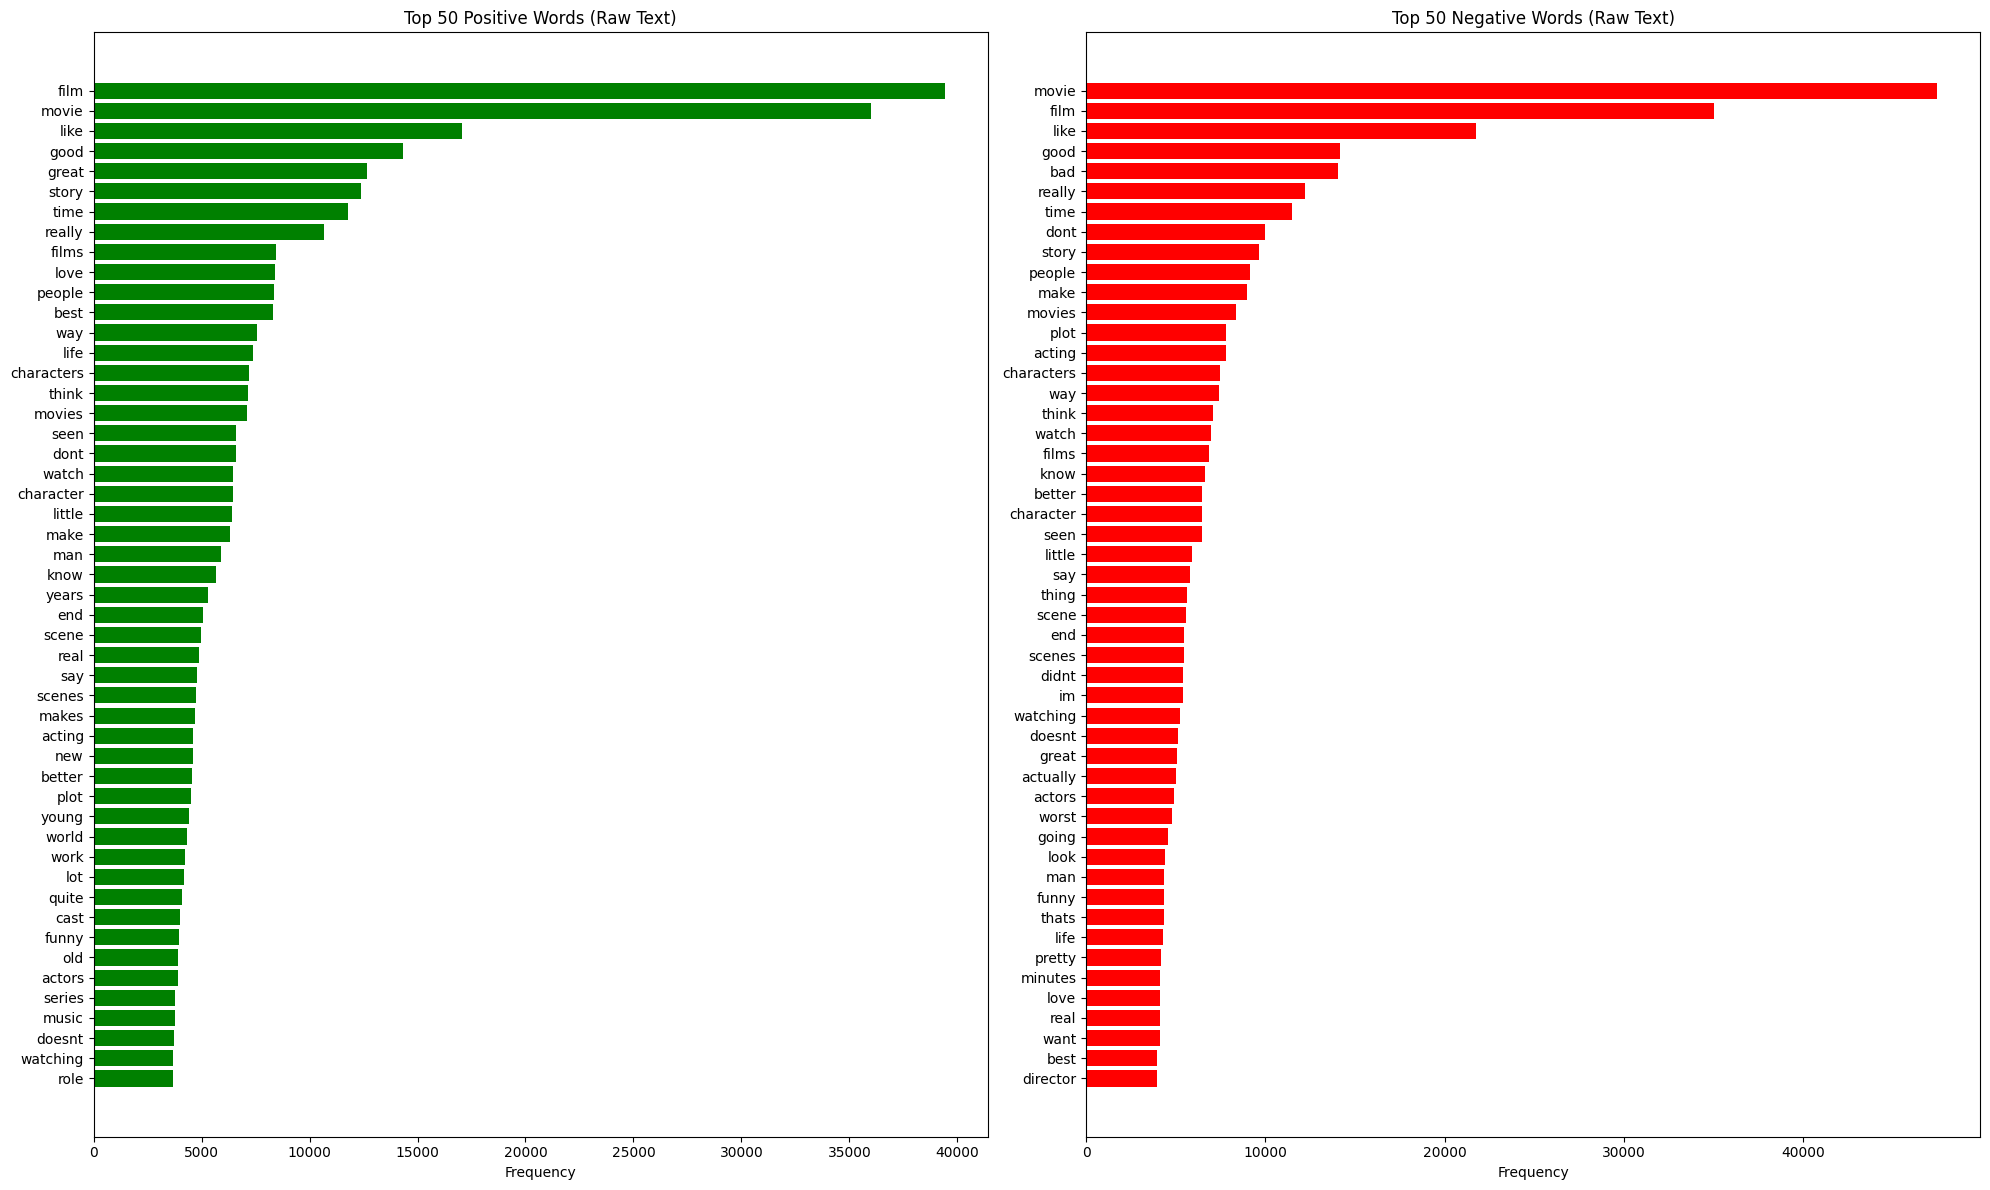

In [ ]:
def plot_top_words(texts, labels, n=100, title_suffix=""):
    # Split into positive/negative
    positive_texts = texts[labels == 1]
    negative_texts = texts[labels == 0]

    # Vectorize without limiting features
    vectorizer = CountVectorizer(stop_words='english', max_features=10000)

    # Get positive words
    pos_counts = vectorizer.fit_transform(positive_texts)
    pos_words = vectorizer.get_feature_names_out()
    pos_freq = np.asarray(pos_counts.sum(axis=0)).ravel()

    # Get negative words
    neg_counts = vectorizer.fit_transform(negative_texts)
    neg_words = vectorizer.get_feature_names_out()
    neg_freq = np.asarray(neg_counts.sum(axis=0)).ravel()

    # Create dataframes
    pos_df = pd.DataFrame({'word': pos_words, 'count': pos_freq})
    neg_df = pd.DataFrame({'word': neg_words, 'count': neg_freq})

    # Sort and select top N
    pos_top = pos_df.sort_values('count', ascending=False).head(n)
    neg_top = neg_df.sort_values('count', ascending=False).head(n)

    # Plotting
    plt.figure(figsize=(20, 12))

    # Positive words
    plt.subplot(1, 2, 1)
    plt.barh(pos_top['word'][::-1], pos_top['count'][::-1], color='green')
    plt.title(f'Top {n} Positive Words {title_suffix}')
    plt.xlabel('Frequency')

    # Negative words
    plt.subplot(1, 2, 2)
    plt.barh(neg_top['word'][::-1], neg_top['count'][::-1], color='red')
    plt.title(f'Top {n} Negative Words {title_suffix}')
    plt.xlabel('Frequency')

    plt.tight_layout()
    plt.show()

# Use original texts before full preprocessing
plot_top_words(df['processed_review'], df['label'], n=50, title_suffix="(Raw Text)")


BIGRAM'S BAR CHART

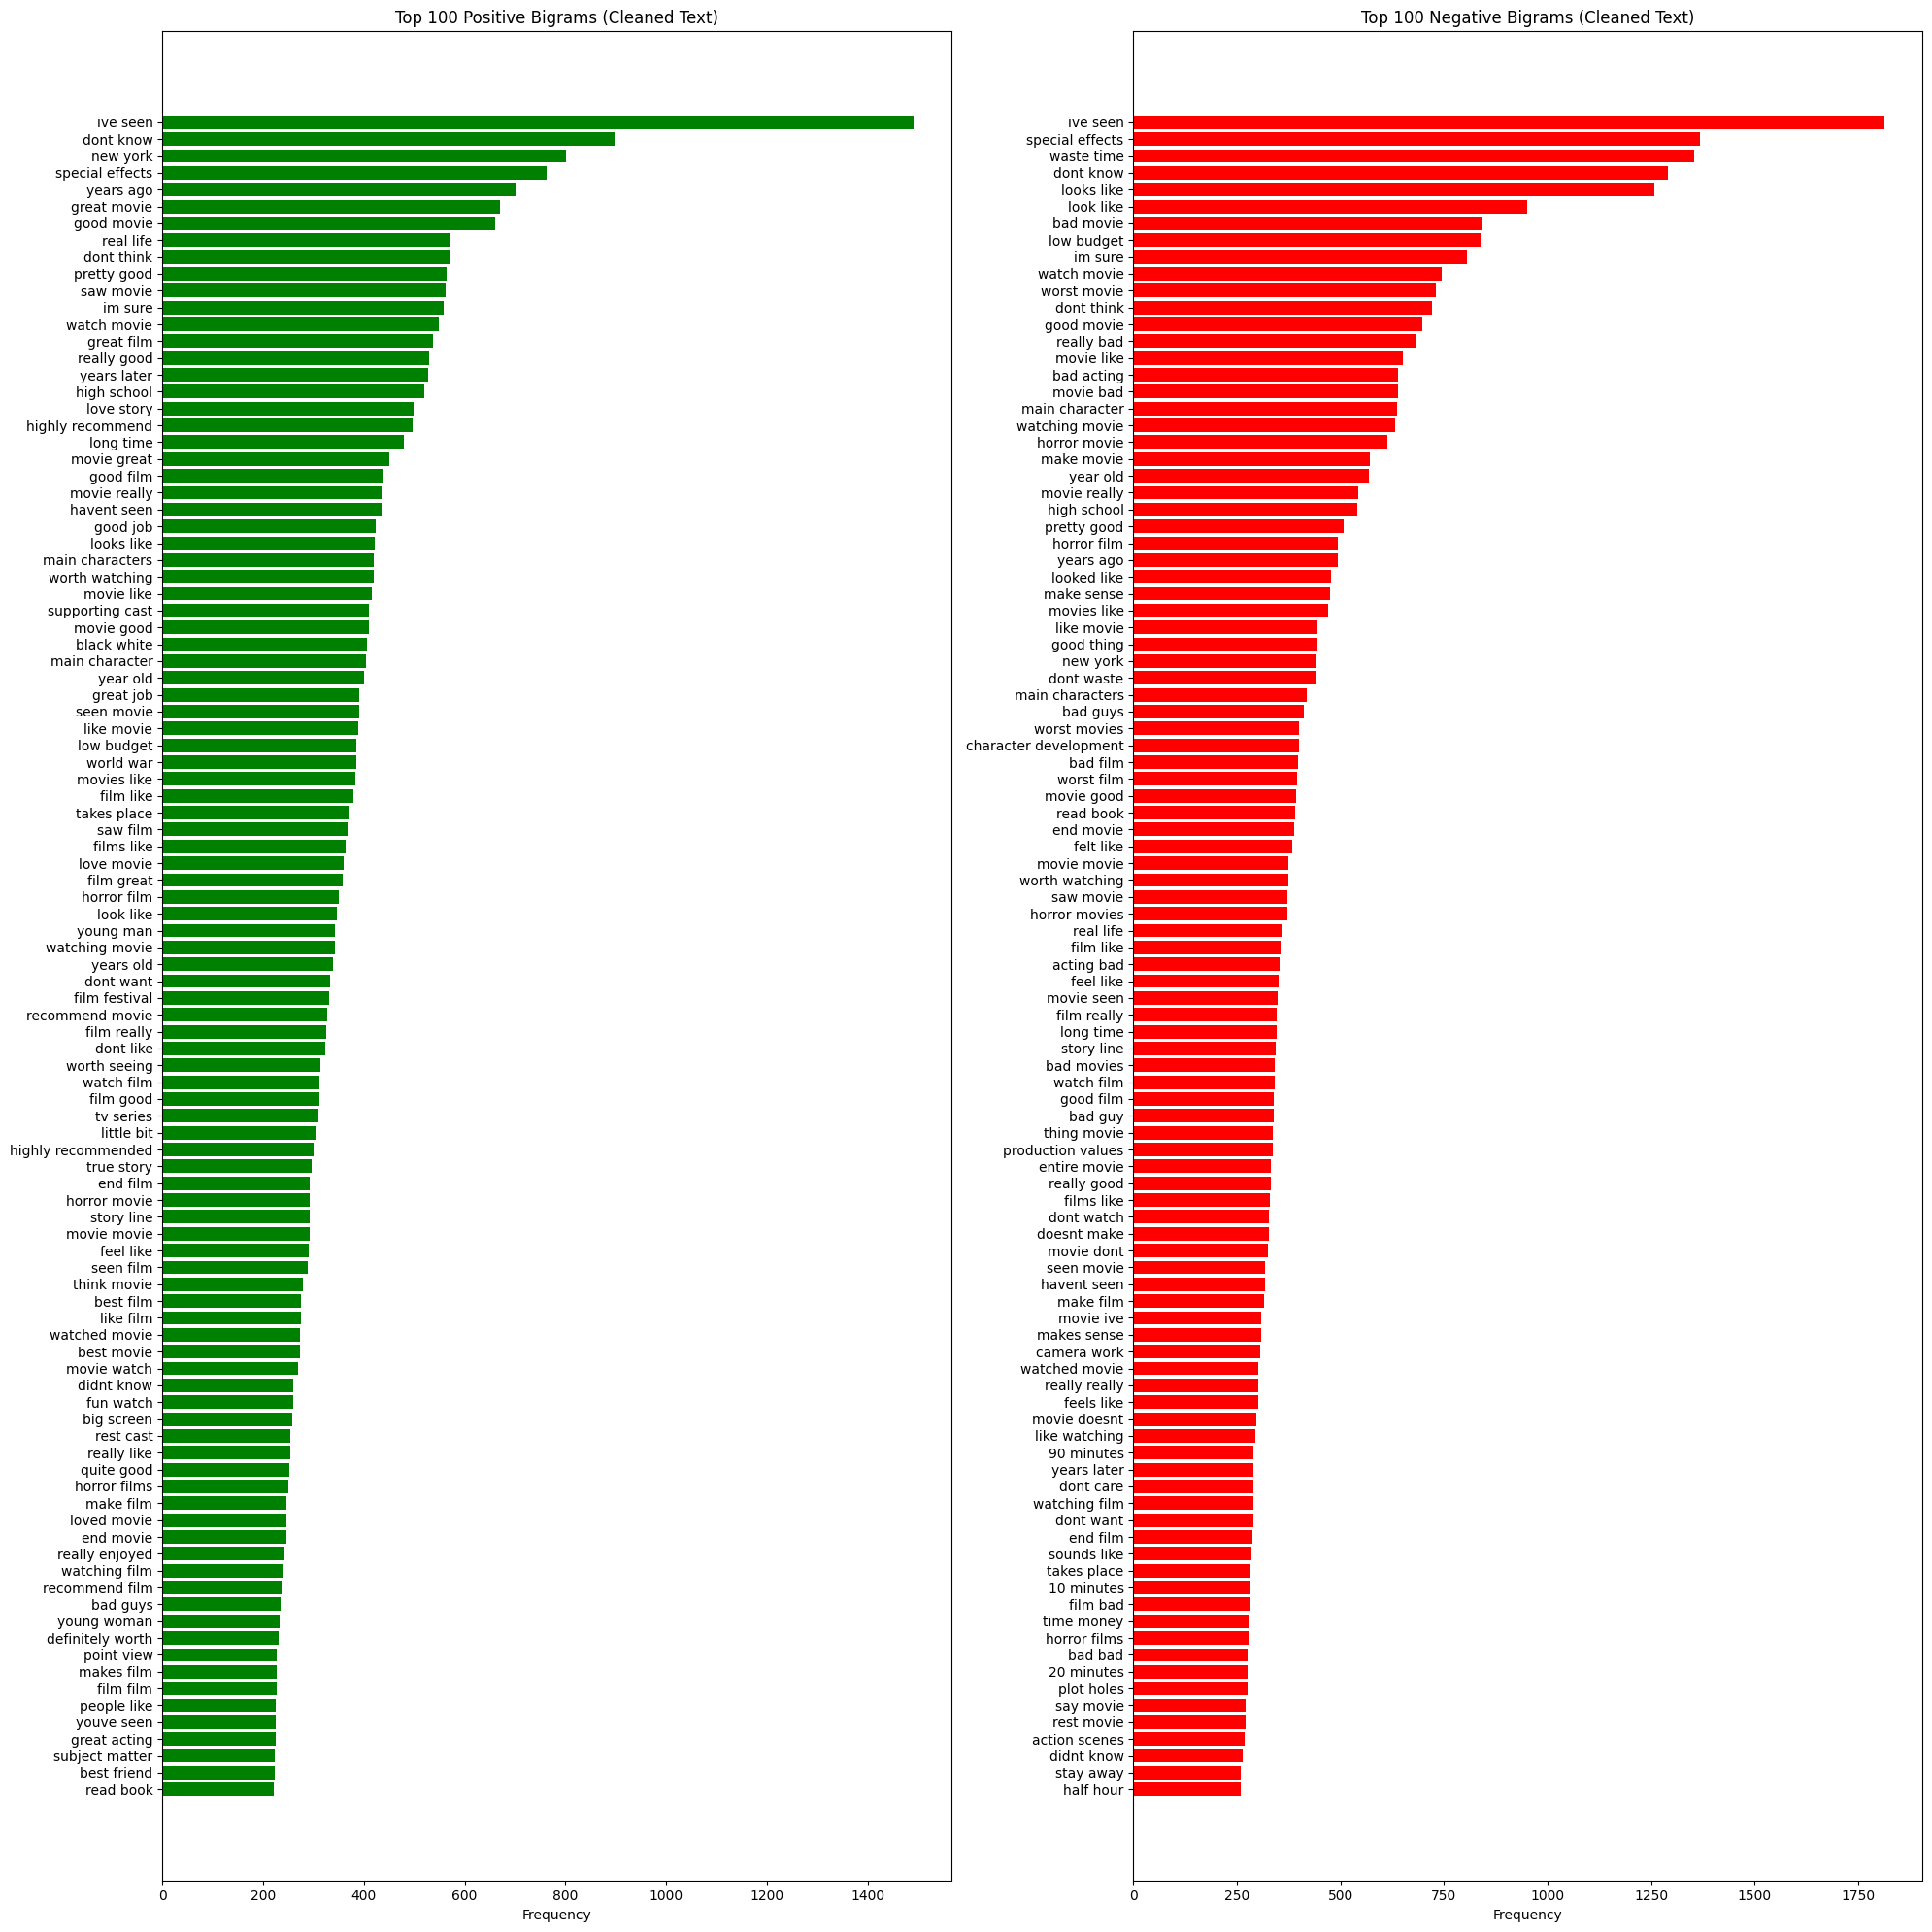

In [ ]:
def plot_top_bigrams(texts, labels, n=100, title_suffix=""):
    # Split into positive/negative
    positive_texts = texts[labels == 1]
    negative_texts = texts[labels == 0]

    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=10000, stop_words='english')

    # Get positive bigrams
    pos_counts = vectorizer.fit_transform(positive_texts)
    pos_bigrams = vectorizer.get_feature_names_out()
    pos_freq = np.asarray(pos_counts.sum(axis=0)).ravel()

    # Get negative bigrams
    neg_counts = vectorizer.fit_transform(negative_texts)
    neg_bigrams = vectorizer.get_feature_names_out()
    neg_freq = np.asarray(neg_counts.sum(axis=0)).ravel()

    # Create dataframes
    pos_df = pd.DataFrame({'bigram': pos_bigrams, 'count': pos_freq})
    neg_df = pd.DataFrame({'bigram': neg_bigrams, 'count': neg_freq})

    # Sort and select top N
    pos_top = pos_df.sort_values('count', ascending=False).head(n)
    neg_top = neg_df.sort_values('count', ascending=False).head(n)

    # Plotting
    plt.figure(figsize=(20, 20))

    # Positive bigrams
    plt.subplot(1, 2, 1)
    plt.barh(pos_top['bigram'][::-1], pos_top['count'][::-1], color='green')
    plt.title(f'Top {n} Positive Bigrams {title_suffix}')
    plt.xlabel('Frequency')

    # Negative bigrams
    plt.subplot(1, 2, 2)
    plt.barh(neg_top['bigram'][::-1], neg_top['count'][::-1], color='red')
    plt.title(f'Top {n} Negative Bigrams {title_suffix}')
    plt.xlabel('Frequency')

    plt.tight_layout()
    plt.show()

# Use processed reviews
plot_top_bigrams(df['processed_review'], df['label'], n=100, title_suffix="(Cleaned Text)")

UNIGRAM BINARY METHOD

In [ ]:
# method 1 : UNIGRAM BINARY
binary_vectorizer = CountVectorizer(binary= True , max_features= 15000 )
x_train_binary = binary_vectorizer.fit_transform(train_texts)
x_validation_binary = binary_vectorizer.transform(validation_texts)
x_test_binary = binary_vectorizer.transform(test_texts)


LOGISTIC REGRESSION ON UNIGRAM BINARY METHOD

In [ ]:

# logisticregression on unigram binary :
reg= LogisticRegression()
reg.fit(x_train_binary , train_labels )
validation_prediction1 = reg.predict(x_validation_binary)
test_prediction1 = reg.predict(x_test_binary)
validation_accuracy1 = accuracy_score(validation_labels , validation_prediction1)
test_accuracy1 = accuracy_score(test_labels , test_prediction1)
print ("LogisticRegression : ")
print ("validation_accuracy : " , validation_accuracy1)
print ("test_accuracy : " , test_accuracy1)


LogisticRegression : 
validation_accuracy :  0.8752
test_accuracy :  0.8716


VISULIZATIONN

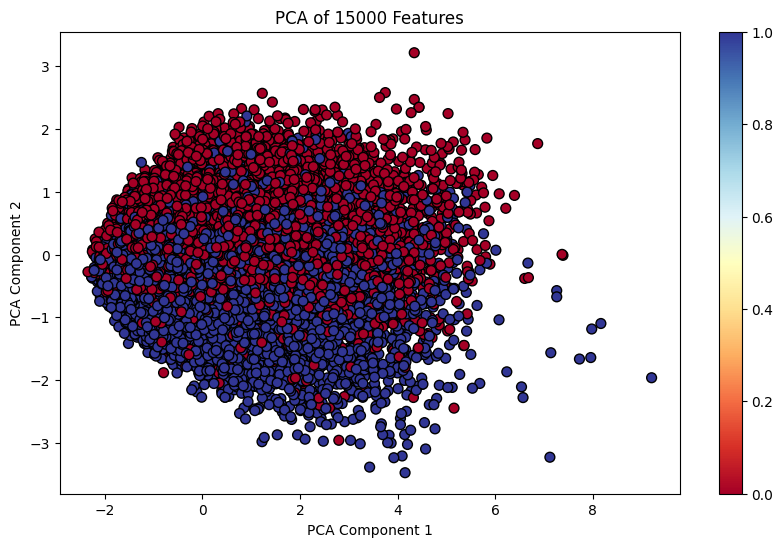

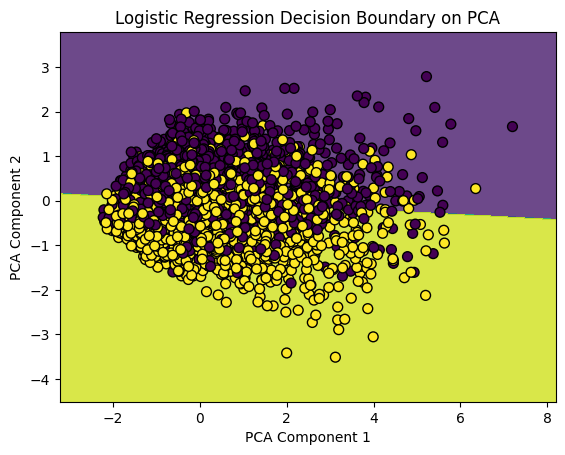

In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
pca = PCA(n_components=2)

X_reduced = pca.fit_transform(x_train_binary)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_labels , cmap=plt.cm.RdYlBu, edgecolor='k', s=50)
plt.title('PCA of 15000 Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter)
plt.show()
X_train_pca = pca.fit_transform(x_train_binary)
X_test_pca = pca.transform(x_test_binary)

reg = LogisticRegression ()
reg.fit(X_test_pca, test_labels)

def plot_decision_boundary(model, X, y):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))


    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)


    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)  # Data points
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Logistic Regression Decision Boundary on PCA')
    plt.show()


plot_decision_boundary(reg, X_test_pca, test_labels)

NAIVE BAYES  ON UNIGRAM BINARY METHOD

In [ ]:
# Naive bayes on unigram binary

nb = MultinomialNB()
nb.fit(x_train_binary , train_labels )
validation_prediction3 = nb.predict(x_validation_binary)
test_prediction3 = nb.predict(x_test_binary)
validation_accuracy3 = accuracy_score(validation_labels , validation_prediction3)
test_accuracy3 = accuracy_score(test_labels , test_prediction3)
print ("NAIVE BAYES : ")
print ("validation_accuracy : " , validation_accuracy3)
print ("test_accuracy : " , test_accuracy3)

NAIVE BAYES : 
validation_accuracy :  0.8525
test_accuracy :  0.861


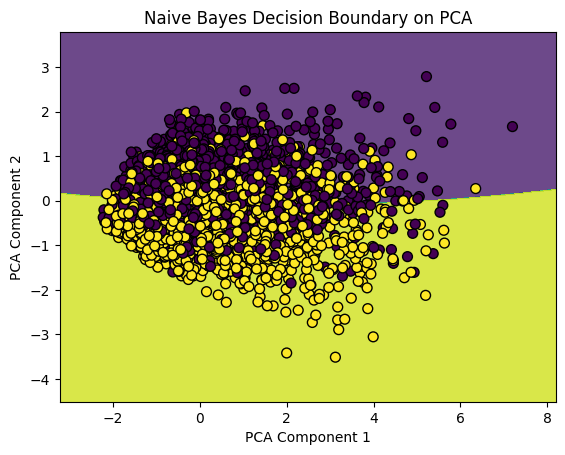

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_test_pca, test_labels)
def plot_decision_boundary(model, X, y):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)  # Data points
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Naive Bayes Decision Boundary on PCA')
    plt.show()
plot_decision_boundary(gnb, X_test_pca,test_labels)

SVM ON UNIGRAM BINARY METHOD

In [ ]:

#SVM on unigram binary :

svm = SVC(kernel='linear' , max_iter=20000)
svm.fit(x_train_binary , train_labels )
validation_prediction2 = svm.predict(x_validation_binary)
test_prediction2 = svm.predict(x_test_binary)
validation_accuracy2 = accuracy_score(validation_labels , validation_prediction2)
test_accuracy2 = accuracy_score(test_labels , test_prediction2)
print ("SVM : ")
print ("validation_accuracy : " , validation_accuracy2)
print ("test_accuracy : " , test_accuracy2)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM : 
validation_accuracy :  0.8417
test_accuracy :  0.8414


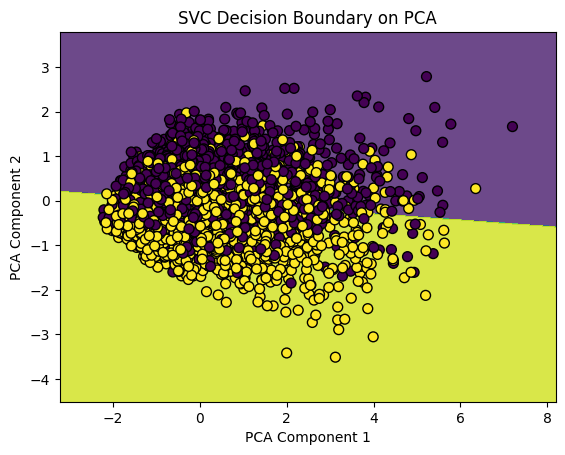

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_test_pca, test_labels)


def plot_decision_boundary(model, X, y):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))


    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)


    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('SVC Decision Boundary on PCA')
    plt.show()

# Plot the decision boundary using the training data
plot_decision_boundary(svm, X_test_pca, test_labels)

UNIGRAM TFIDF METHOD

In [ ]:
# UNIGRAM TFIDF METHOD :
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
x_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
x_validation_tfidf = tfidf_vectorizer.transform(validation_texts)
x_test_tfidf = tfidf_vectorizer.transform(test_texts)


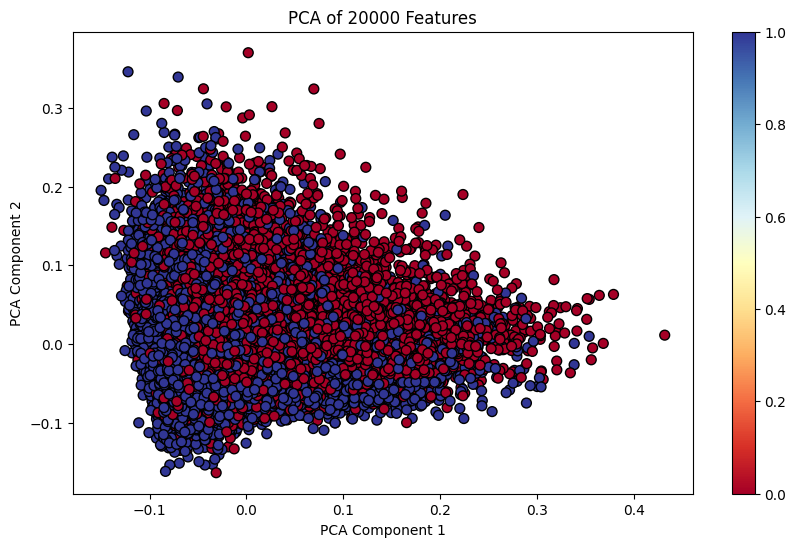

In [ ]:
pca = PCA(n_components=2)

X_reduced = pca.fit_transform(x_train_tfidf)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_labels , cmap=plt.cm.RdYlBu, edgecolor='k', s=50)
plt.title('PCA of 20000 Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter)
plt.show()
X_train_pca = pca.fit_transform(x_train_tfidf)
X_test_pca = pca.transform(x_test_tfidf)

LOGISTIC REGRESSION ON UNIGRAM TFIDF METHID :

In [ ]:

# logisticregression on unigram tfidf :
reg= LogisticRegression()
reg.fit(x_train_tfidf , train_labels )
validation_prediction4 = reg.predict(x_validation_tfidf)
test_prediction4 = reg.predict(x_test_tfidf)
validation_accuracy4 = accuracy_score(validation_labels , validation_prediction4)
test_accuracy4 = accuracy_score(test_labels , test_prediction4)
print ("LogisticRegression : ")
print ("validation_accuracy : " , validation_accuracy4)
print ("test_accuracy : " , test_accuracy4)


LogisticRegression : 
validation_accuracy :  0.8951
test_accuracy :  0.8948


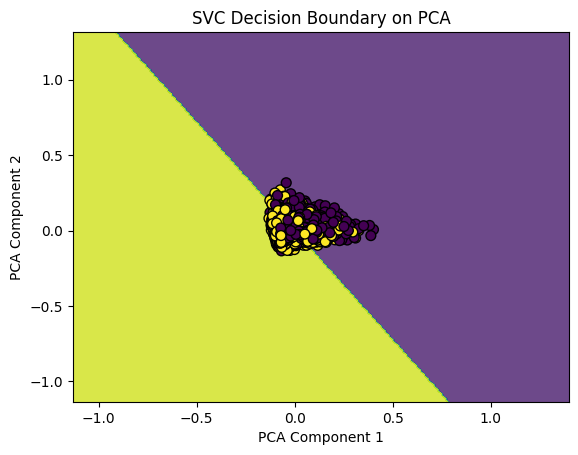

In [ ]:
reg.fit(X_test_pca, test_labels)
plot_decision_boundary(reg, X_test_pca, test_labels)

NAIVE BAYES  ON UNIGRAM  TFIDF METHOD  

In [ ]:

# Naive bayes on unigram tfidf :

nb = MultinomialNB()
nb.fit(x_train_tfidf , train_labels )
validation_prediction6 = nb.predict(x_validation_tfidf)
test_prediction6 = nb.predict(x_test_tfidf)
validation_accuracy6 = accuracy_score(validation_labels , validation_prediction6)
test_accuracy6 = accuracy_score(test_labels , test_prediction6)
print ("NAIVE BAYES : ")
print ("validation_accuracy : " , validation_accuracy6)
print ("test_accuracy : " , test_accuracy6)





NAIVE BAYES : 
validation_accuracy :  0.8598
test_accuracy :  0.8658


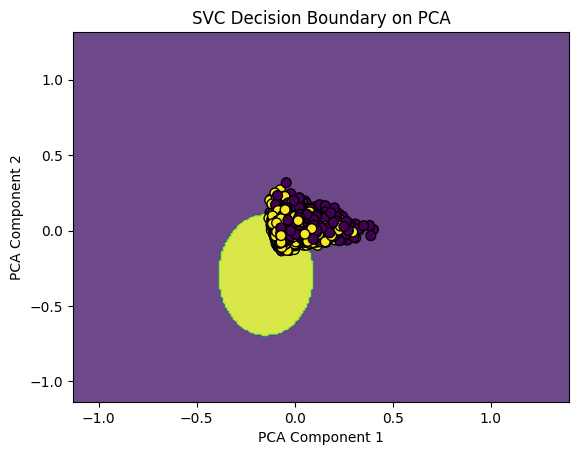

In [ ]:
gnb.fit(X_test_pca, test_labels)
plot_decision_boundary(gnb, X_test_pca, test_labels)

SVM  ON UNIGRAM TFIDF METHOD   

In [ ]:

#SVM on unigram tfidf :
svm = SVC(kernel='linear' , max_iter=20000)
svm.fit(x_train_tfidf, train_labels )
validation_prediction5 = svm.predict(x_validation_tfidf)
test_prediction5 = svm.predict(x_test_tfidf)
validation_accuracy5 = accuracy_score(validation_labels , validation_prediction5)
test_accuracy5= accuracy_score(test_labels , test_prediction5)
print ("SVM : ")
print ("validation_accuracy : " , validation_accuracy5)
print ("test_accuracy : " , test_accuracy5)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM : 
validation_accuracy :  0.8979
test_accuracy :  0.89


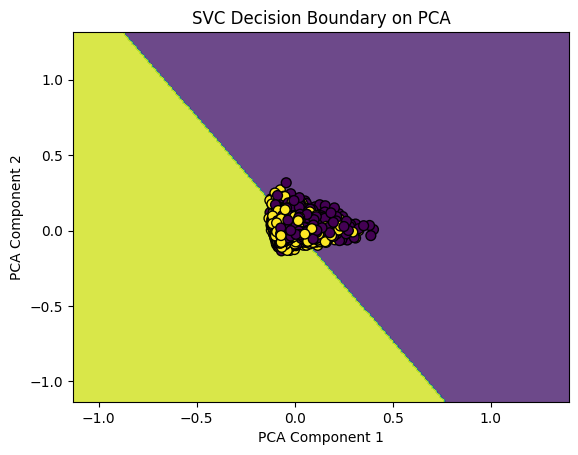

In [ ]:
svm = SVC(kernel='linear' , max_iter=20000)
svm.fit(X_test_pca, test_labels)
plot_decision_boundary(svm, X_test_pca, test_labels)


BIGRAM + UNIGRAM  BINARY METHOD

In [ ]:
# method 3 : BIGRAM + UNIGRAM BINARY
bigram_binary_vectorizer = CountVectorizer(ngram_range=(1, 2), binary= True , max_features= 80000)
x_train_bigram_binary = bigram_binary_vectorizer.fit_transform(train_texts)
x_validation_bigram_binary = bigram_binary_vectorizer.transform(validation_texts)
x_test_bigram_binary = bigram_binary_vectorizer.transform(test_texts)


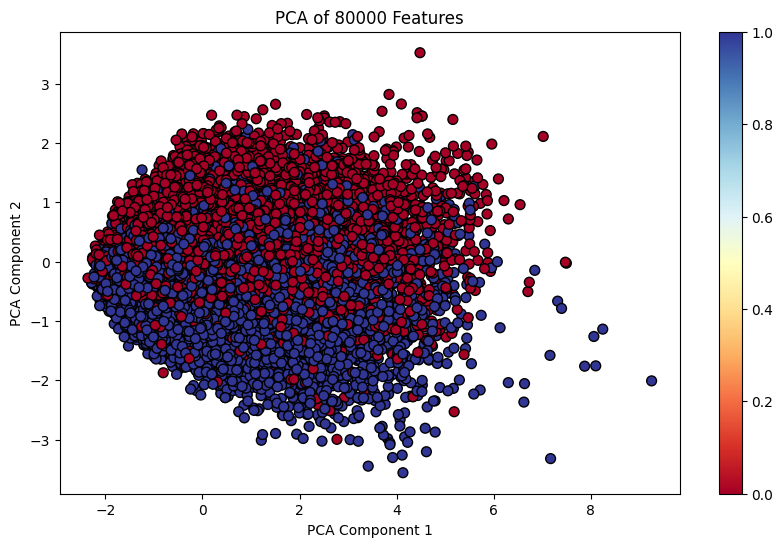

In [ ]:
pca = PCA(n_components=2)

X_reduced = pca.fit_transform( x_train_bigram_binary)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_labels , cmap=plt.cm.RdYlBu, edgecolor='k', s=50)
plt.title('PCA of 80000 Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter)
plt.show()
X_train_pca = pca.fit_transform( x_train_bigram_binary)
X_test_pca = pca.transform( x_test_bigram_binary)

LOGISTIC REGRESSION ON BIGRAM+UNIGRAM BINARY

In [ ]:
#logistic regression on bigram binary
reg= LogisticRegression()
reg.fit(x_train_bigram_binary , train_labels )
validation_prediction7= reg.predict(x_validation_bigram_binary)
test_prediction7 = reg.predict(x_test_bigram_binary)
validation_accuracy7 = accuracy_score(validation_labels , validation_prediction7)
test_accuracy7 = accuracy_score(test_labels , test_prediction7)
print ("LogisticRegression : ")
print ("validation_accuracy : " , validation_accuracy7)
print ("test_accuracy : " , test_accuracy7)


LogisticRegression : 
validation_accuracy :  0.8985
test_accuracy :  0.8906


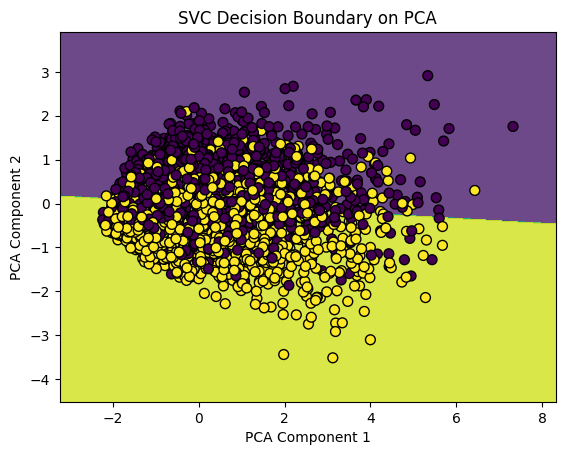

In [ ]:
reg.fit(X_test_pca, test_labels)
plot_decision_boundary(reg, X_test_pca, test_labels)

NAIVE BAYES ON  BIGRAM+UNIGRAM BINARY

In [ ]:
# Naive bayes on BIGRAM+UNIGRAM  BINARY :

nb = MultinomialNB()
nb.fit(x_train_bigram_binary , train_labels )
validation_prediction8 = nb.predict(x_validation_bigram_binary)
test_prediction8 = nb.predict(x_test_bigram_binary)
validation_accuracy8 = accuracy_score(validation_labels , validation_prediction8)
test_accuracy8 = accuracy_score(test_labels , test_prediction8)
print ("NAIVE BAYES : ")
print ("validation_accuracy : " , validation_accuracy8)
print ("test_accuracy : " , test_accuracy8)


NAIVE BAYES : 
validation_accuracy :  0.8795
test_accuracy :  0.8832


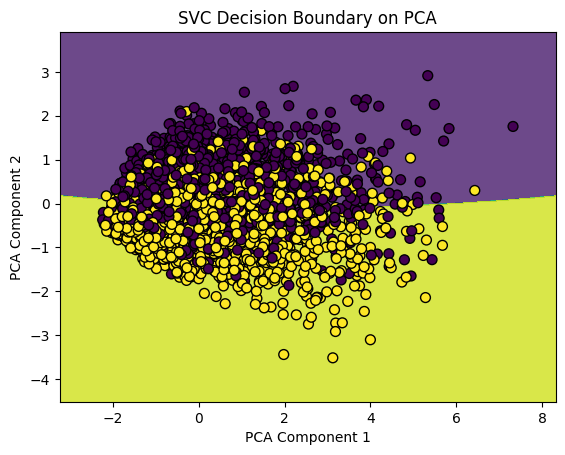

In [ ]:
gnb.fit(X_test_pca, test_labels)
plot_decision_boundary(gnb, X_test_pca, test_labels)

SVM ON BIGRAM+UNIGRAM BINARY

In [ ]:
#SVM on bigram+UNIGRAM binary :
svm = SVC(kernel='linear' , max_iter= 50000)
svm.fit(x_train_bigram_binary, train_labels )
validation_prediction9 = svm.predict(x_validation_bigram_binary)
test_prediction9 = svm.predict(x_test_bigram_binary)
validation_accuracy9 = accuracy_score(validation_labels , validation_prediction9)
test_accuracy9= accuracy_score(test_labels , test_prediction9)
print ("SVM : ")
print ("validation_accuracy : " , validation_accuracy9)
print ("test_accuracy : " , test_accuracy9)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM : 
validation_accuracy :  0.8885
test_accuracy :  0.874


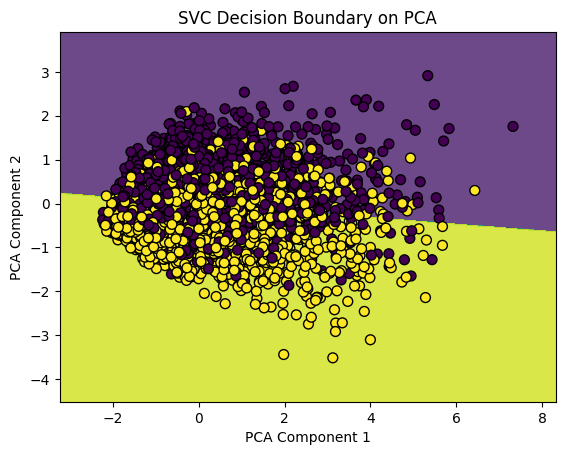

In [ ]:
svm = SVC(kernel='linear' , max_iter=50000)
svm.fit(X_test_pca, test_labels)
plot_decision_boundary(svm, X_test_pca, test_labels)



BIGRAM+UNIGRAM TFIDF METHOD

In [ ]:
# METHOD 4 : BIGRAM + UNIGRAM TFIDF
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=150000)
x_train_bigram_tfidf = bigram_tfidf_vectorizer.fit_transform(train_texts)
x_validation_bigram_tfidf = bigram_tfidf_vectorizer.transform(validation_texts)
x_test_bigram_tfidf = bigram_tfidf_vectorizer.transform(test_texts)

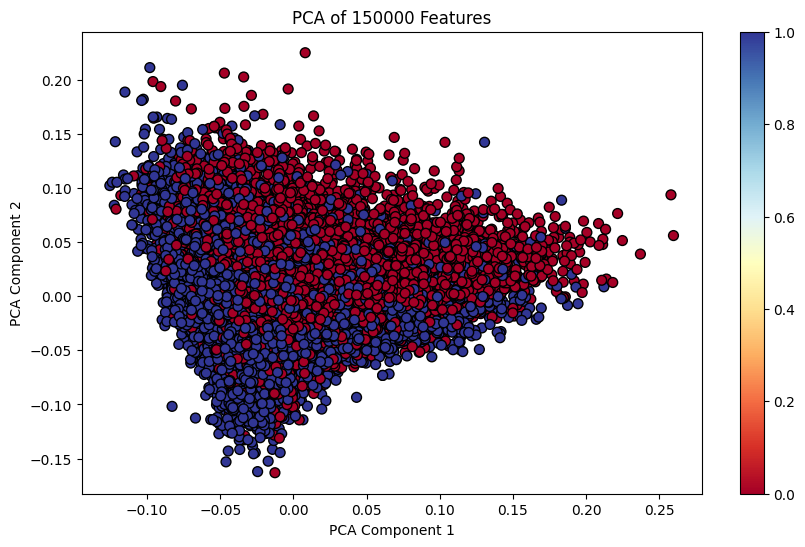

In [ ]:
pca = PCA(n_components=2)

X_reduced = pca.fit_transform(  x_train_bigram_tfidf)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_labels , cmap=plt.cm.RdYlBu, edgecolor='k', s=50)
plt.title('PCA of 150000 Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter)
plt.show()
X_train_pca = pca.fit_transform(  x_train_bigram_tfidf)
X_test_pca = pca.transform( x_test_bigram_tfidf)

LOGISTIC REGREWSSION ON BIGRAM+UNIGRAM TFIDF

In [ ]:
#logistic regression on bigram+UNIGRAM TFIDF
reg= LogisticRegression()
reg.fit(x_train_bigram_tfidf , train_labels )
validation_prediction10= reg.predict(x_validation_bigram_tfidf)
test_prediction10 = reg.predict(x_test_bigram_tfidf)
validation_accuracy10 = accuracy_score(validation_labels , validation_prediction10)
test_accuracy10 = accuracy_score(test_labels , test_prediction10)
print ("LogisticRegression : ")
print ("validation_accuracy : " , validation_accuracy10)
print ("test_accuracy : " , test_accuracy10)

LogisticRegression : 
validation_accuracy :  0.9003
test_accuracy :  0.899


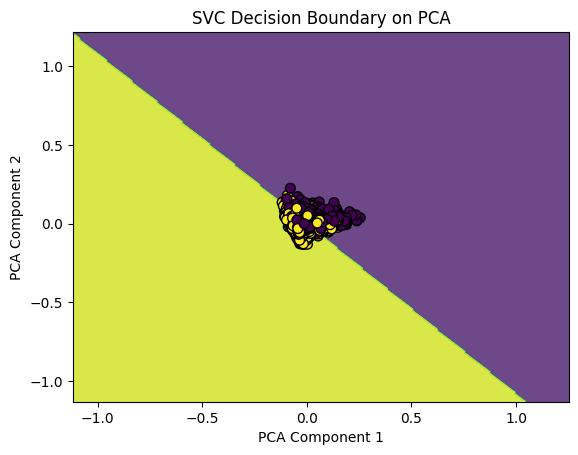

In [ ]:
reg.fit(X_test_pca, test_labels)
plot_decision_boundary(reg, X_test_pca, test_labels)

NAIVE BAYES ON BIGRAM+UNIGRAM TFIDF

In [ ]:
# Naive bayes on BIGRAM+UNIGRAM TFIDF :

nb = MultinomialNB()
nb.fit(x_train_bigram_tfidf, train_labels )
validation_prediction11 = nb.predict(x_validation_bigram_tfidf)
test_prediction11 = nb.predict(x_test_bigram_tfidf)
validation_accuracy11 = accuracy_score(validation_labels , validation_prediction11)
test_accuracy11 = accuracy_score(test_labels , test_prediction11)
print ("NAIVE BAYES : ")
print ("validation_accuracy : " , validation_accuracy11)
print ("test_accuracy : " , test_accuracy11)


NAIVE BAYES : 
validation_accuracy :  0.8851
test_accuracy :  0.8862


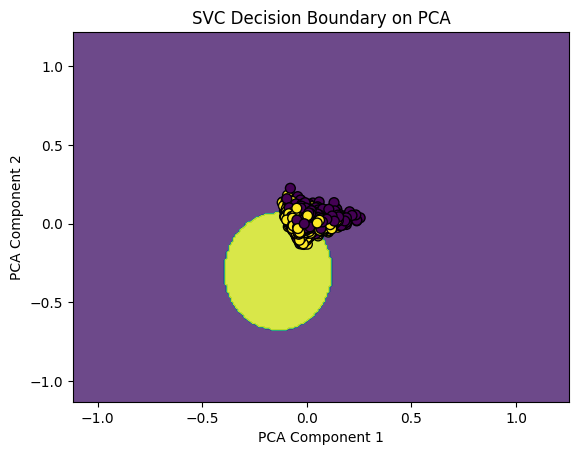

In [ ]:
gnb.fit(X_test_pca, test_labels)
plot_decision_boundary(gnb, X_test_pca, test_labels)

SVM ON BIGRAM+UNIGRAM TFIDF

In [ ]:
#SVM on bigram+UNIGRAM TFIDF :
svm = SVC(kernel='linear' , max_iter= 50000)
svm.fit(x_train_bigram_tfidf, train_labels )
validation_prediction12 = svm.predict(x_validation_bigram_tfidf)
test_prediction12 = svm.predict(x_test_bigram_tfidf)
validation_accuracy12 = accuracy_score(validation_labels , validation_prediction12)
test_accuracy12 = accuracy_score(test_labels , test_prediction12)
print ("SVM : ")
print ("validation_accuracy : " , validation_accuracy12)
print ("test_accuracy : " , test_accuracy12)


SVM : 
validation_accuracy :  0.9076
test_accuracy :  0.9032


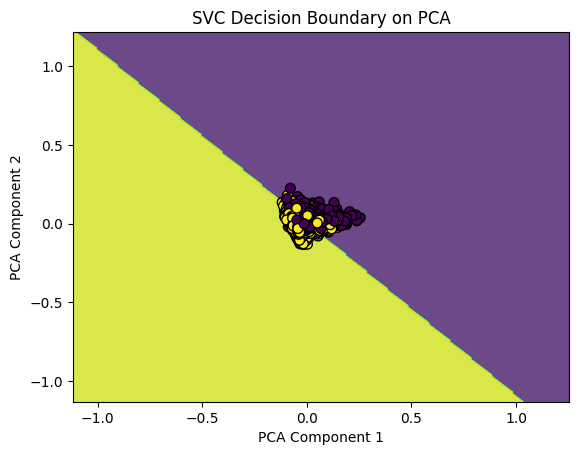

In [ ]:
svm = SVC(kernel='linear' , max_iter=50000)
svm.fit(X_test_pca, test_labels)
plot_decision_boundary(svm, X_test_pca, test_labels)
